In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
import yfinance as yf 
import matplotlib.ticker as mtick
import os 
plt.style.use("ggplot")

data_folder = 'C:/Users/tanma/OneDrive/Desktop/Data-Anlaytics-Projects-24/Sentiment-analysis-trading'

data = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

data['date'] = pd.to_datetime(data['date'])

data = data.set_index(['date', 'symbol'])

data['engagement_ratio']=data['twitterComments']/data['twitterLikes']

data = data[(data['twitterLikes']>50) & (data['twitterLikes']>40)]

data

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25034 rows x 6 columns]

Aggregated monthly and calculated average senitments for a month

In [23]:
aggregated_df = (data.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())
aggregated_df['rank'] = (aggregated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))
aggregated_df               

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.260749  21.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  17.0
           TSLA            0.151992  72.0
           TSN             0.280553  27.0
           V               0.194045  59.0
           XOM             0.217904  52.0

[1107 rows x 2 columns]

Selecting Top 5 stocks for each month

In [24]:
filtered_df = aggregated_df[aggregated_df['rank']<6].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index+pd.DateOffset(1)
filtered_df=filtered_df.reset_index().set_index(['date','symbol'])
filtered_df.head(20)


engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 BA              0.634488   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.184916   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.592924   4.0
           OXY             1.025579   3.0

Extract Stocks to form portfolio with start of each new month

In [25]:
dates=filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates={}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['BA', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CRM', 'DD', 'FCX', 'GS', 'STZ'],
 '2022-08-01': ['DD', 'JPM', 'META', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'META', 'STZ'],
 '2022-12-01': ['AES', 'DAL', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'C', 'DAL', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

Download fresh stock prices of these shortlisted stocks

In [26]:
stocks_list = data.index.get_level_values('symbol').unique().tolist()
stocks_list.remove('ATVI')

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2024-11-05')

[*********************100%%**********************]  84 of 84 completed


Calculate Portfolio Returns With monthly rebalancing

In [27]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df


,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


DOWNLOAD NASDAQ AND QQQ DATA FOR COMPARISON

In [28]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2024-11-05')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017542
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


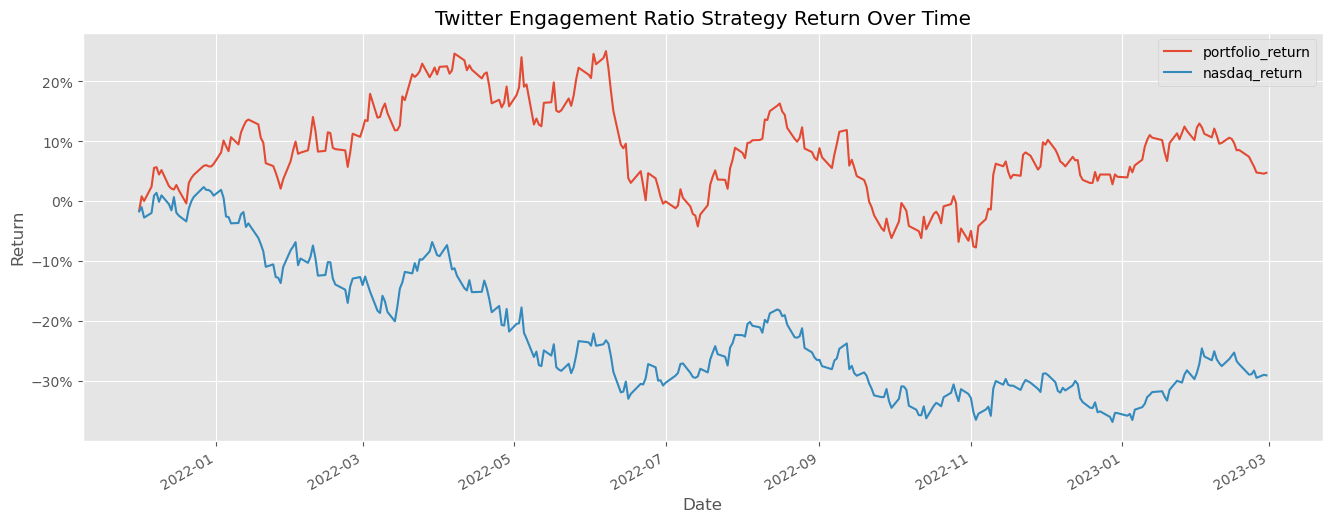

In [29]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()